# Introduction

So... you've got some interesting property of the network uncovered. Is it real? How can you trust that what you've found **didn't arise by random chance**?

One useful way of thinking by using generative models of random graphs. By "generative" and "random", we mean that the graph was generated using some statistical random model underlying it. This is essentially in the "Bayesian" tradition of modelling.

The alternative is a non-parametric way of thinking. This is where we don't assume some model that generated the data, and instead performs randomization on the data on hand to calculate statistics. Here, we assume that our randomization procedure is an appropriate random model for the network.

## Statistics Primer

**Discrete Distributions:**

- Bernoulli: probability p of success in 1 try (e.g. one flip of coin).
- Binomial: probability p of success given n number of tries. `n * bernoulli trials` follows binomial distribution.
- Poisson: processes with a per-unit rate.

**Continuous Distributions:**

- Uniform: equal probability over the range of probable values. Can also be made discrete.
- Normal: everyone's favourite.

We can also make up an arbitrary distribution of our own. :-)

## Statistical Test of Significance of Busy Routes

If we think back to the graph made in the previous notebook, what kind of process might one imagine that gave rise to the data?

**brainstorm session...**

Group work.

## Discrete uniform distribution over all routes

Assumptions of this model:

1. Riders choose start station with uniform probability.
2. They then choose a destination station with uniform probability.
3. They ride it and the data are recorded.

Under this model, what is the distribution of number of rides taken throughout the ? We can probably solve this analytically, but since we have ultra-cheap computational capabilities at our fingertips, might as well do it the brute-force way.

In [1]:
import networkx as nx

G = nx.read_gpickle('datasets/divvy_2013/divvy_graph.pkl')
total_trips = sum([d['count'] for _,_,d in G.edges(data=True)])
print(total_trips)

759788


### Exercise

Calculate the expected number of trips between any two stations, assuming self-loops are allowed.

In [2]:
float(total_trips) / len(G.nodes()) ** 2

8.44208888888889

### Exercise

Can you plot a histogram of the number of trips taken on each route?

<Container object of 406 artists>

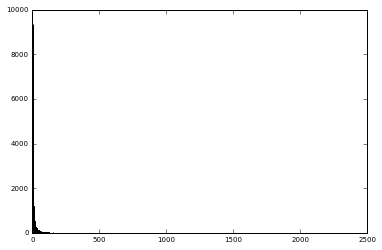

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

num_trips = [d['count'] for _,_,d in G.edges(data=True)]

plt.bar(Counter(num_trips).keys(), Counter(num_trips).values())

### Exercise

Can you figure out the 2.5th, 97.5th, and 100th percentile of this distribution?

Hint: You may wish to use `numpy`'s `percentile` function.

In [4]:
import numpy as np

np.percentile(num_trips, [2.5, 97.5, 100])

array([  1.00000000e+00,   1.10000000e+02,   2.11300000e+03])

Computing the interval between the 2.5th to the 97.5th percentile effectively gives you a centered 95% mass of the distribution. Knowing this range can be quite useful in other data analysis cases.

### Live Class Exercise

Together, we will implement a random model for the number of trips that are taken between two stations.

In this procedure, we will copy the nodes graph `G` into a new graph `G_random`. This can be done by:

    G_random = nx.Graph()
    G_random.add_nodes_from(G.nodes(data=True))
    
Following that, we will manually map-reduce this computation.

In [5]:
# Grab all the nodes from G.
G_random = nx.Graph()
G_random.add_nodes_from(G.nodes(data=True))
G_random.nodes(data=True)

[(5,
  {'dpcapacity': 19,
   'landmark': 30,
   'latitude': 41.87395806,
   'longitude': -87.62773949,
   'name': 'State St & Harrison St',
   'online date': Timestamp('2013-06-28 00:00:00')}),
 (13,
  {'dpcapacity': 19,
   'landmark': 66,
   'latitude': 41.93250008,
   'longitude': -87.65268082,
   'name': 'Wilton Ave & Diversey Pkwy',
   'online date': Timestamp('2013-06-28 00:00:00')}),
 (14,
  {'dpcapacity': 15,
   'landmark': 163,
   'latitude': 41.858086,
   'longitude': -87.651073,
   'name': 'Morgan St & 18th St',
   'online date': Timestamp('2013-06-28 00:00:00')}),
 (15,
  {'dpcapacity': 15,
   'landmark': 164,
   'latitude': 41.85818061,
   'longitude': -87.65648665,
   'name': 'Racine Ave & 18th St',
   'online date': Timestamp('2013-06-28 00:00:00')}),
 (16,
  {'dpcapacity': 15,
   'landmark': 223,
   'latitude': 41.910329,
   'longitude': -87.672516,
   'name': 'Wood St & North Ave',
   'online date': Timestamp('2013-08-12 00:00:00')}),
 (17,
  {'dpcapacity': 15,
   'land

Here is an attempt at writing a numpy-vectorized version of the simulation.

Once again, this is inspired by Jake VDP's PyCon talk on using numpy.

The core idea here is as such:

1. Assume all possible edges had a unique index.
2. We can store this in an array of size n_nodes^2.
3. We can generate random integers in a second array of size `total trips`, but with maximum value `edges`.
4. We then create a histogram using `np.histogram(trip_edges, bins=num_edges+1)`. This returns two arrays:
    1. an array with the number of trips in each edge
    2. an array with the bin numbers (representing the edges).

This here will be much faster than brute-force iteration because we use `numpy` functions.

Special thanks to Mauris Van Hauwe on Stack Overflow: http://stackoverflow.com/questions/29578781/how-to-vectorize-simulation-of-distributing-coins-in-numpy/29578883#29578883

8.44208888889 8.47191296988


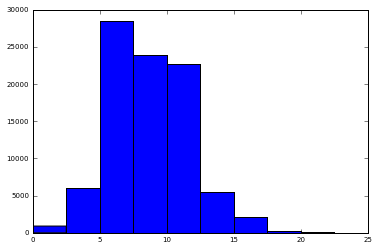

In [8]:
# Total number of possible edges.
edges = len(G.nodes())**2

# Recall that the total trips was recorded in the variable total_trips
total_trips

# coins = 800000
# slots = 900000

trip_edges = np.random.randint(edges, size=total_trips) 
trips_in_each_edge = np.histogram(trip_edges, bins=np.arange(edges+1))[0]
trips_in_each_edge
plt.hist(trips_in_each_edge)
print(np.mean(trips_in_each_edge), np.var(trips_in_each_edge))

**Think about it...**

Given the distribution of trip counts in the randomly re-distributed trips, what can we infer about the popularity of certain routes? Are they likely to have shown up in this random model?